# Data Exploration

This notebook is for exploring and visualizing the data.

In [61]:
import os
import re

import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import pylangacq

from tqdm import tqdm
import string
punctuations = string.punctuation

In [62]:
# Define PATH
ADReSS2020_DATAPATH = "../data/ADReSS-IS2020-data"
ADReSS2020_TRAINPATH = os.path.join(ADReSS2020_DATAPATH, "train")
ADReSS2020_TESTPATH = os.path.join(ADReSS2020_DATAPATH, "test")

TRANSCRIPT_NAME = "transcription"

In [63]:
def read_par_utterances(file_path):
    """
    Read a CHAT file and return a list of merged *PAR (and *INV) utterances.
    This function merges continuation lines and removes trailing time codes.
    """
    utterances = []
    current_utterance = None

    with open(file_path, 'r', encoding="utf-8") as f:
        for line in f:
            line = line.rstrip("\n")
            # New utterance: lines starting with *PAR: or *INV:
            if line.startswith("*PAR:") or line.startswith("*INV:"):
                # If an utterance is in progress, finish and store it.
                if current_utterance is not None:
                    # Remove any trailing time code (text between two  symbols)
                    current_utterance = re.sub(r'.*?', '', current_utterance).strip()
                    utterances.append(current_utterance)
                # Start a new utterance (remove the marker)
                if line.startswith("*PAR:"):
                    current_utterance = line[len("*PAR:"):].strip()
                else:
                    current_utterance = line[len("*INV:"):].strip()
            # Continuation lines (indented or containing a time code marker) are appended.
            elif current_utterance is not None and ('' in line):
                current_utterance += " " + line.strip()
            # Otherwise, ignore the line.
    
    # Append the final utterance if one is in progress.
    if current_utterance:
        current_utterance = re.sub(r'.*?', '', current_utterance).strip()
        utterances.append(current_utterance)
    
    return utterances

def is_retracing(token):
    """
    Determine if a token is a retracing token that should be merged with the previous token.
    
    Returns True for tokens matching patterns like:
      - o(f)
      - fallin(g)
      - an(d)
      - stealin(g)
    (case-insensitive)
    
    But returns False for tokens such as (.), (..), or (...).
    """
    pattern = re.compile(r'^(an|o|stealin|takin)\([^)]*\)$', re.IGNORECASE)
    if pattern.match(token):
        return True
    return False

def merge_annotation_tokens(tokens, start_index):
    """
    Merge tokens that are part of an annotation enclosed in brackets.
    This function supports both square-bracket annotations (e.g., "[+ exc]") and
    angle-bracket annotations (e.g., "<walk with a>").
    
    Returns a tuple of (merged_token, next_index).
    """
    token = tokens[start_index]
    if token.startswith('['):
        closing = ']'
    elif token.startswith('<'):
        closing = '>'
    else:
        return token, start_index + 1

    merged = token
    i = start_index
    # If the token already ends with the closing bracket, return it.
    if merged.endswith(closing):
        return merged, i + 1
    i += 1
    # Merge subsequent tokens until we find one that ends with the closing bracket.
    while i < len(tokens) and not tokens[i].endswith(closing):
        merged += " " + tokens[i]
        i += 1
    if i < len(tokens):
        merged += " " + tokens[i]
        i += 1
    return merged, i

def tokenize_and_merge(utterance):
    """
    Tokenize an utterance into tokens with the following custom behavior:
    
      - If a token is immediately followed by a retracing token 
        (e.g., 'o(f)', 'fallin(g)', 'an(d)', 'stealin(g)'), merge them into a single token 
        by concatenating with the linking_token.
      - Merge bracketed annotations so that tokens like "[+ exc]" or "[: overflowing]" 
        and angle-bracket annotations like "<walk with a>" remain intact.
    
    Returns a list of tokens.
    """
    tokens = utterance.split()
    merged_tokens = []
    i = 0
    while i < len(tokens):
        token = tokens[i]
        
        # If the token begins with '[' or '<' but does not end with the corresponding closing bracket,
        # merge the entire annotation.
        if (token.startswith('[') and not token.endswith(']')) or (token.startswith('<') and not token.endswith('>')):
            merged_token, i = merge_annotation_tokens(tokens, i)
            merged_tokens.append(merged_token)
            continue
        
        merged_tokens.append(token)
        i += 1
        
    return merged_tokens

In [64]:
def get_chat_data(split):
    """
    Get the CHAT data from the ADReSS-IS2020 dataset.
    
    Parameters:
        split (str): The split to load (either "train" or "test").
        data_path (str): The path to the ADReSS-IS2020 dataset.
    
    Returns:
        List[Tuple[List[str], int]]: A list of (tokens, label) tuples.
    """
    path = ADReSS2020_TRAINPATH if split == "train" else ADReSS2020_TESTPATH
    # Define the path to the transcript files.
    transcript_path = os.path.join(path, TRANSCRIPT_NAME)
    # Read the CHAT data.
    reader = pylangacq.read_chat(transcript_path)

    file_paths = reader.file_paths()
    data = []

    test_df = pd.read_csv(ADReSS2020_DATAPATH + '/2020Labels.txt', delimiter=';', skipinitialspace=True)
    test_df = test_df.drop(columns=['age', 'mmse', 'gender'], axis=1)

    # Read and merge utterances from each file.
    for file_path in file_paths:
        # Read and merge *PAR utterances.
        utterances = read_par_utterances(file_path)

        # Tokenize and merge tokens from each utterance.
        all_tokens = []
        for utt in utterances:
            tokens = tokenize_and_merge(utt)
            all_tokens.extend([token for token in tokens if token not in list(punctuations)])

        if split == 'test':
            label = test_df[test_df['ID'] == os.path.basename(file_path).split('.')[0] + ' '].Label.iloc[0]
        
        elif split == 'train':
            label = 0 if 'cc' in file_path else 1

        data.append((all_tokens, label))

    return data

In [65]:
train_data = get_chat_data("train")
train_data[0]

(['tell',
  'me',
  'everything',
  'that',
  'you',
  'see',
  'going',
  'on',
  'in',
  'that',
  'picture',
  'everything',
  'that',
  'you',
  'see',
  'happening',
  'well',
  "there's",
  'a',
  'mother',
  'standing',
  'there',
  '&uh',
  '&uh',
  'washing',
  'the',
  'dishes',
  'an(d)',
  'the',
  'sink',
  'is',
  'overspilling',
  '[: overflowing]',
  '[* s:r]',
  'an(d)',
  '&uh',
  'the',
  "window's",
  'open',
  'and',
  'outside',
  'the',
  'window',
  "there's",
  'a',
  '<walk with a>',
  '[//]',
  '&c',
  'curved',
  'walk',
  'with',
  'a',
  'garden',
  'and',
  'you',
  'can',
  'see',
  'another',
  '&uh',
  '&uh',
  'building',
  'there',
  'looks',
  'like',
  'a',
  'garage',
  'or',
  'something',
  'with',
  'curtains',
  'and',
  'the',
  'grass',
  'in',
  'the',
  'garden',
  'and',
  'there',
  'are',
  'dishes',
  '[//]',
  '&uh',
  '&uh',
  'two',
  'cups',
  'and',
  'a',
  'saucer',
  'on',
  'the',
  'sink',
  'and',
  '&uh',
  "she's",
  'gett

<Axes: title={'center': 'Label distribution in the training set'}, xlabel='label'>

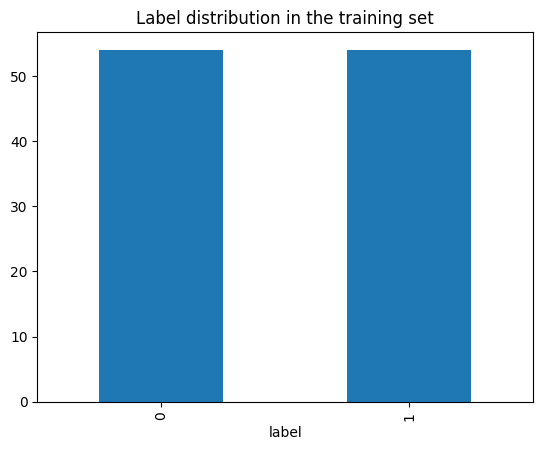

In [66]:
train_data = get_chat_data("train")
train_data = pd.DataFrame(train_data, columns=['tokens', 'label'])
train_data.label.value_counts().plot(kind='bar', title='Label distribution in the training set')

<Axes: title={'center': 'Label distribution in the testing set'}, xlabel='label'>

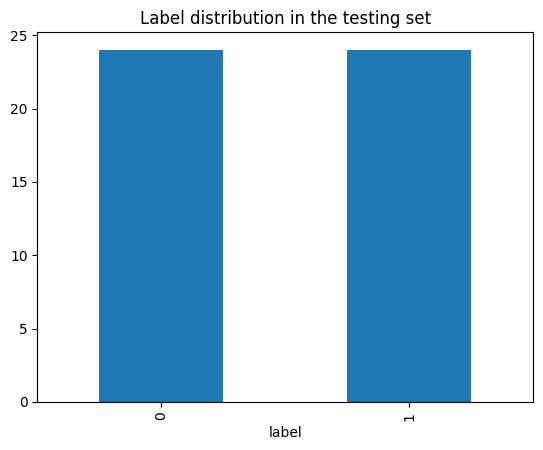

In [67]:
test_data = get_chat_data("test")
test_data = pd.DataFrame(test_data, columns=['tokens', 'label'])
test_data.label.value_counts().plot(kind='bar', title='Label distribution in the testing set')

<Axes: title={'center': 'Distribution of the number of tokens in the training set'}, ylabel='Frequency'>

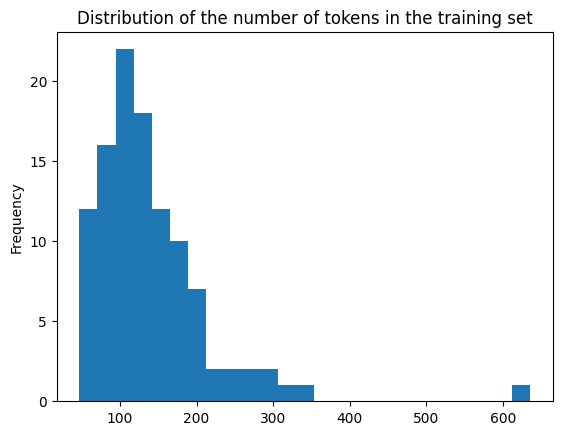

In [68]:
# Plot the distribution of the number of tokens in the training set.
train_data['num_tokens'] = train_data['tokens'].apply(len)
train_data['num_tokens'].plot(kind='hist', bins=25, title='Distribution of the number of tokens in the training set')

<Axes: title={'center': 'Distribution of the number of tokens in the testing set'}, ylabel='Frequency'>

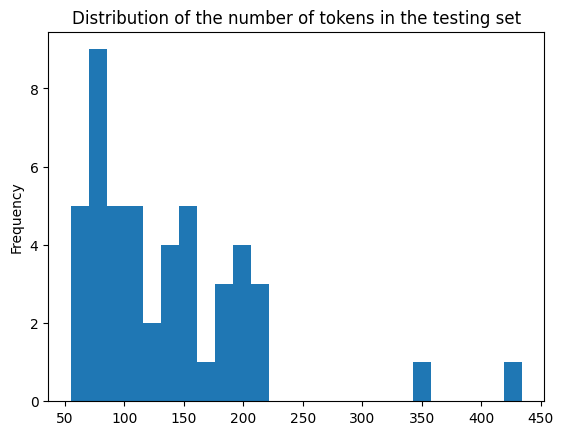

In [69]:
# Plot the distribution of the number of tokens in the testing set.
test_data['num_tokens'] = test_data['tokens'].apply(len)
test_data['num_tokens'].plot(kind='hist', bins=25, title='Distribution of the number of tokens in the testing set')


In [70]:
train_data

,tokens,label,num_tokens
0,"[tell, me, everything, that, you, see, going, ...",0,200
1,"[just, look, at, the, picture, and, tell, me, ...",0,110
2,"[okay, [+ exc], there's, a, little, boy, and, ...",0,165
3,"[are, you, ready, [+ exc], mhm, &um, well, the...",0,287
4,"[okay, there's, the, picture, okay, [+ exc], g...",0,159
...,...,...,...
103,"[well, the, boy, on, the, chair, [: stool], [*...",1,64
104,"[everything, that, you, see, happening, in, th...",1,71
105,"[picture, and, tell, me, everything, that, you...",1,120
106,"[okay, the, picture, tell, me, everything, +/....",1,61


## 300 token iz fine!!!

In [71]:
" ".join(train_data.iloc[0].tokens)

"tell me everything that you see going on in that picture everything that you see happening well there's a mother standing there &uh &uh washing the dishes an(d) the sink is overspilling [: overflowing] [* s:r] an(d) &uh the window's open and outside the window there's a <walk with a> [//] &c curved walk with a garden and you can see another &uh &uh building there looks like a garage or something with curtains and the grass in the garden and there are dishes [//] &uh &uh two cups and a saucer on the sink and &uh she's getting her feet wet from the overflow of the water from the sink she seems to be oblivious to the fact that the &s sink is overflowing she's also oblivious to the fact that her kids are stealin(g) cookies out o(f) the cookie jar and the kid on the stool is gonna fall off the stool he's standing up there in the cupboard takin(g) cookies out o(f) the kids are somewhere around seven or eight years old or nine an(d) the mother is gonna get shocked <when the> [/] when the [//

In [72]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
enc._special_tokens.update({'<|pad|>': 50257})
enc.encode(" ".join(train_data.iloc[0].tokens), allowed_special={'<|pad|>'})

[33331,
 502,
 2279,
 326,
 345,
 766,
 1016,
 319,
 287,
 326,
 4286,
 2279,
 326,
 345,
 766,
 5836,
 880,
 612,
 338,
 257,
 2802,
 5055,
 612,
 1222,
 7456,
 1222,
 7456,
 20518,
 262,
 16759,
 281,
 7,
 67,
 8,
 262,
 14595,
 318,
 625,
 2777,
 4509,
 685,
 25,
 43347,
 60,
 30138,
 264,
 25,
 81,
 60,
 281,
 7,
 67,
 8,
 1222,
 7456,
 262,
 4324,
 338,
 1280,
 290,
 2354,
 262,
 4324,
 612,
 338,
 257,
 1279,
 11152,
 351,
 257,
 29,
 685,
 1003,
 60,
 1222,
 66,
 26929,
 2513,
 351,
 257,
 11376,
 290,
 345,
 460,
 766,
 1194,
 1222,
 7456,
 1222,
 7456,
 2615,
 612,
 3073,
 588,
 257,
 15591,
 393,
 1223,
 351,
 41160,
 290,
 262,
 8701,
 287,
 262,
 11376,
 290,
 612,
 389,
 16759,
 685,
 1003,
 60,
 1222,
 7456,
 1222,
 7456,
 734,
 14180,
 290,
 257,
 473,
 48915,
 319,
 262,
 14595,
 290,
 1222,
 7456,
 673,
 338,
 1972,
 607,
 3625,
 9583,
 422,
 262,
 30343,
 286,
 262,
 1660,
 422,
 262,
 14595,
 673,
 2331,
 284,
 307,
 38603,
 284,
 262,
 1109,
 326,
 262,
 1222,
 82,


<Axes: title={'center': 'Distribution of the number of encoded tokens in the training set'}, ylabel='Frequency'>

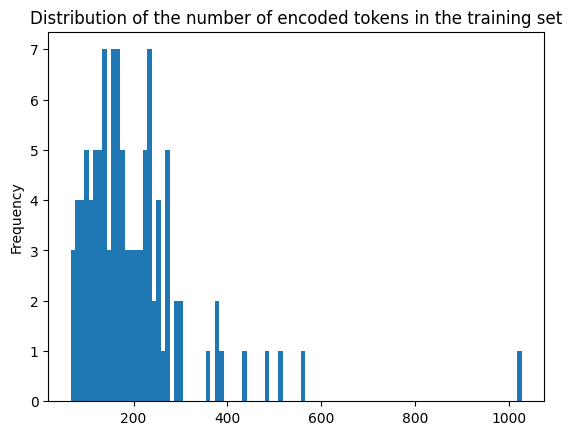

In [73]:
# Encode the tokens using the GPT-2 tokenizer.
train_data['encoded'] = train_data['tokens'].apply(lambda x: enc.encode(" ".join(x)))
train_data['encoded'].apply(len).plot(kind='hist', bins=100, title='Distribution of the number of encoded tokens in the training set')

In [74]:
# Get the number of unique tokens in the training set.
unique_tokens = set()
for tokens in train_data['tokens']:
    unique_tokens.update(tokens)
len(unique_tokens)

1224

In [75]:
# If the tokens is more than max_len, split the tokens into 2 parts and append the second part to the next row
# If the tokens is less than max_len, adding padding to the tokens if that, duplicate the label
def split_tokens(tokens, max_len=100):
    if len(tokens) <= max_len:
        return [tokens + [50257] * (max_len - len(tokens))]
    else:
        split = [tokens[i:i+max_len] for i in range(0, len(tokens), max_len)]
        split[-1] += [50257] * (max_len - len(split[-1]))
        return split
    
train_data['encoded'] = train_data['encoded'].apply(split_tokens)
train_data = train_data.explode('encoded').reset_index(drop=True)
train_data

,tokens,label,num_tokens,encoded
0,"[tell, me, everything, that, you, see, going, ...",0,200,"[33331, 502, 2279, 326, 345, 766, 1016, 319, 2..."
1,"[tell, me, everything, that, you, see, going, ...",0,200,"[290, 262, 8701, 287, 262, 11376, 290, 612, 38..."
2,"[tell, me, everything, that, you, see, going, ...",0,200,"[612, 287, 262, 6508, 3526, 256, 27048, 7, 70,..."
3,"[just, look, at, the, picture, and, tell, me, ...",0,110,"[3137, 804, 379, 262, 4286, 290, 1560, 502, 22..."
4,"[just, look, at, the, picture, and, tell, me, ...",0,110,"[319, 262, 13447, 1222, 388, 2802, 5729, 1595,..."
...,...,...,...,...
263,"[picture, and, tell, me, everything, that, you...",1,120,"[34053, 290, 1560, 502, 2279, 326, 345, 766, 5..."
264,"[picture, and, tell, me, everything, that, you...",1,120,"[290, 612, 338, 257, 1310, 2576, 351, 683, 290..."
265,"[okay, the, picture, tell, me, everything, +/....",1,61,"[482, 323, 262, 4286, 1560, 502, 2279, 1343, 1..."
266,"[picture, okay, mhm, [+ exc], can, you, tell, ...",1,122,"[34053, 8788, 285, 23940, 26076, 2859, 60, 460..."


In [15]:
train_data = train_data.explode('encoded_split')

In [16]:
train_data

,tokens,label,num_tokens,encoded,encoded_split
0,"[tell, me, everything, that, you, see, going, ...",0,200,"[33331, 502, 2279, 326, 345, 766, 1016, 319, 2...","[33331, 502, 2279, 326, 345, 766, 1016, 319, 2..."
1,"[just, look, at, the, picture, and, tell, me, ...",0,110,"[3137, 804, 379, 262, 4286, 290, 1560, 502, 22...","[3137, 804, 379, 262, 4286, 290, 1560, 502, 22..."
2,"[okay, [+ exc], there's, a, little, boy, and, ...",0,165,"[482, 323, 26076, 2859, 60, 612, 338, 257, 131...","[482, 323, 26076, 2859, 60, 612, 338, 257, 131..."
3,"[are, you, ready, [+ exc], mhm, &um, well, the...",0,287,"[533, 345, 3492, 26076, 2859, 60, 285, 23940, ...","[533, 345, 3492, 26076, 2859, 60, 285, 23940, ..."
4,"[okay, there's, the, picture, okay, [+ exc], g...",0,159,"[482, 323, 612, 338, 262, 4286, 8788, 26076, 2...","[482, 323, 612, 338, 262, 4286, 8788, 26076, 2..."
...,...,...,...,...,...
103,"[well, the, boy, on, the, chair, [: stool], [*...",1,64,"[4053, 262, 2933, 319, 262, 5118, 685, 25, 387...","[4053, 262, 2933, 319, 262, 5118, 685, 25, 387..."
104,"[everything, that, you, see, happening, in, th...",1,71,"[37814, 326, 345, 766, 5836, 287, 326, 4286, 1...","[37814, 326, 345, 766, 5836, 287, 326, 4286, 1..."
105,"[picture, and, tell, me, everything, that, you...",1,120,"[34053, 290, 1560, 502, 2279, 326, 345, 766, 5...","[34053, 290, 1560, 502, 2279, 326, 345, 766, 5..."
106,"[okay, the, picture, tell, me, everything, +/....",1,61,"[482, 323, 262, 4286, 1560, 502, 2279, 1343, 1...","[482, 323, 262, 4286, 1560, 502, 2279, 1343, 1..."


In [157]:
check_text = train_data['token_splits'][0]

In [164]:
decode_text = enc.decode([i for i in check_text if i != 50257])
decode_text

"tell me everything that you see going on in that picture everything that you see happening well there's a mother standing there &uh &uh washing the dishes an(d) the sink is overspilling [: overflowing] [* s:r] an(d) &uh the window's open and outside the window there's a <walk with a> [//] &c curved walk with a garden and you can see another &uh &uh building there looks like a garage or something with curtains and the grass in the garden and there are dishes [//] &uh &uh two cups and a saucer on the sink and &uh she's getting her feet wet from the overflow of the water from the sink she seems to be oblivious to the fact that the &s sink is overflowing she's also oblivious to the fact that her kids are stealin(g) cookies out o(f) the cookie jar and the kid on the stool is gonna fall off the stool he's standing up there in the cupboard takin(g) cookies out o(f) the kids are somewhere around seven or eight years old or nine an(d) the mother is gonna get shocked <when the> [/] when the [//

In [77]:
train_data['encoded'][0]

[33331,
 502,
 2279,
 326,
 345,
 766,
 1016,
 319,
 287,
 326,
 4286,
 2279,
 326,
 345,
 766,
 5836,
 880,
 612,
 338,
 257,
 2802,
 5055,
 612,
 1222,
 7456,
 1222,
 7456,
 20518,
 262,
 16759,
 281,
 7,
 67,
 8,
 262,
 14595,
 318,
 625,
 2777,
 4509,
 685,
 25,
 43347,
 60,
 30138,
 264,
 25,
 81,
 60,
 281,
 7,
 67,
 8,
 1222,
 7456,
 262,
 4324,
 338,
 1280,
 290,
 2354,
 262,
 4324,
 612,
 338,
 257,
 1279,
 11152,
 351,
 257,
 29,
 685,
 1003,
 60,
 1222,
 66,
 26929,
 2513,
 351,
 257,
 11376,
 290,
 345,
 460,
 766,
 1194,
 1222,
 7456,
 1222,
 7456,
 2615,
 612,
 3073,
 588,
 257,
 15591,
 393,
 1223,
 351,
 41160]

In [81]:
2**15

32768

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

text = "The capital of France is [MASK]."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# To get predictions for the mask:
masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)
print("Predicted token:", predicted_token)
# Predicted token:  Paris


/home/mjnk/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
